# Summary

Two days of spare time is needed to finish this project. 

The original dataset can be found here: Beauty 5 core review dataset (~45MB) from http://jmcauley.ucsd.edu/data/amazon/.

I will use this dataset and implement two models:
1. Text embeddings and classifier
2. Recommender system

In [1]:
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

ratings= getDF('reviews_Beauty_5.json.gz')

In [2]:
ratings.rename(columns={'reviewerID': 'user_id', 
                        'asin': 'item_id', 
                        'reviewerName': 'user_name', 
                        'reviewText': 'review_text',
                        'summary': 'review_summary',
                        'overall': 'score'},
               inplace=True)


In [3]:
ratings.user_id = ratings.user_id.astype('category').cat.codes.values
ratings.item_id = ratings.item_id.astype('category').cat.codes.values
# Add IDs for embeddings.
ratings['user_emb_id'] = ratings['user_id']
ratings['item_emb_id'] = ratings['item_id']

# Classifier

In [4]:
import spacy
import numpy as np
import sklearn.metrics
nlp_en = spacy.load('en', vectors='en_glove_cc_300_1m')
example_reviews = ratings.review_summary.tolist()
example_embs = np.vstack([nlp_en(e).vector for e in example_reviews])
#sklearn.metrics.pairwise.cosine_similarity(example_embs)

In [20]:
# Multinomial Naive Bayes Classifier
def naive_bayes_classifier(train_x, train_y):
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB(alpha=0.01)
    model.fit(train_x, train_y)
    return model

# KNN Classifier
def knn_classifier(train_x, train_y):
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier()
    model.fit(train_x, train_y)
    return model

# Logistic Regression Classifier
def logistic_regression_classifier(train_x, train_y):
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(penalty='l2')
    model.fit(train_x, train_y)
    return model
 

# Random Forest Classifier
def random_forest_classifier(train_x, train_y):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=8)
    model.fit(train_x, train_y)
    return model
 
# Decision Tree Classifier 
def decision_tree_classifier(train_x, train_y):
    from sklearn import tree
    model = tree.DecisionTreeClassifier()
    model.fit(train_x, train_y)
    return model
 

# GBDT(Gradient Boosting Decision Tree) Classifier
def gradient_boosting_classifier(train_x, train_y):
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(n_estimators=15)
    model.fit(train_x, train_y)
    return model


# SVM Classifier
def svm_classifier(train_x, train_y):
    from sklearn.svm import SVC
    model = SVC(kernel='rbf', probability=True)
    model.fit(train_x, train_y)
    return model
 


In [21]:
scoregeq4 = ratings.score.where(ratings.score>=4, 0)
scoregeq4 = scoregeq4.where(ratings.score<4, 1)


In [62]:
a = np.array(scoregeq4)[np.newaxis].T
data = np.append(a, example_embs, axis=1)
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

In [63]:
train_y = train[:, 0]
train_x = train[:, 1:]
test_y = test[:, 0]
test_x = test[:, 1:]

## Select suitable classifiers and evaluation metric

In the cell below, I tended to use all the classic ml classifiers. 

The purpose of the classification is to alert the user if their score does not match what they have written. However, as we already know, some methods like knn, svm are very slow in such case. Thus I only show the results of logistic regression, random forest, decision tree and gradient boosting decision tree. 

Since this is a binary classification problem, I use precision, recall, auc and accuracy. I prefer not to use accuracy because sometimes the test data is seriously imbalanced. In this case, the true sample is far large than false sample. As for other three indicators, precision, recall and auc. In order to get rid of the influence of threshold value, I decide to use auc as my evaluation metric. 

According the results shown below, RF classifier does better in terms of auc.

In [24]:
import time
from sklearn import metrics
if __name__ == '__main__':
    
    classifiers = {'NB':naive_bayes_classifier,
                  'KNN':knn_classifier,
                   'LR':logistic_regression_classifier,
                   'RF':random_forest_classifier,
                   'DT':decision_tree_classifier,
                  'SVM':svm_classifier,
                 'GBDT':gradient_boosting_classifier} 
    
    test_classifiers = ['LR', 'RF', 'DT', 'GBDT']
    is_binary_class = (len(np.unique(train_y)) == 2)
    
    for classifier in test_classifiers:
        print ('******************* %s ********************' % classifier)
        start_time = time.time()
        model = classifiers[classifier](train_x, train_y)
        print ('training took %fs!' % (time.time() - start_time))
        predict = model.predict(test_x)
        #print(is_binary_class)
        if is_binary_class:
            precision = metrics.precision_score(test_y, predict)
            recall = metrics.recall_score(test_y, predict)
            auc = metrics.roc_auc_score(test_y, predict)
            print ('precision: %.2f%%, recall: %.2f%%, auc: %.2f%%' % (100 * precision, 100 * recall, 100 * auc))
        accuracy = metrics.accuracy_score(test_y, predict)
        print ('accuracy: %.2f%%' % (100 * accuracy))

******************* LR ********************
training took 75.235085s!
precision: 85.04%, recall: 95.10%, auc: 68.32%
accuracy: 83.18%
******************* RF ********************
training took 30.637856s!
precision: 86.28%, recall: 91.57%, auc: 70.34%
accuracy: 82.12%
******************* DT ********************
training took 139.185390s!
precision: 86.16%, recall: 85.62%, auc: 68.78%
accuracy: 78.13%
******************* GBDT ********************
training took 138.457628s!
precision: 80.49%, recall: 99.10%, auc: 57.58%
accuracy: 80.62%


In [37]:
print ('number of true sample: ', len(test_y[test_y==1]))
print ('number of false sample: ', len(test_y[test_y==0]))

number of true sample:  30867
number of false sample:  8834


## Human-interpretable Results

I think it's trivial to analyze whether it does a reasonable job of mapping text. The result already shows most of the prediction matches with original scores. It will become obvious that if the wordcloud of the review summary presents most positive words, the prediction will be high score, vice versa. So I focus on under what condition the prediction will be wrong. 

10 fault sample have been selected. It's interesting to discover that wordcloud will automatically delete useless word like "not" which will impact the result to some extent. "not I expected" will become "expected". "not a gread product" becomes "great". As for the case "better", the machine will think it needs to be better. However it means "cannot be better". Whoo, so much trap for nlp.

In [70]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

b = np.array(ratings.review_summary)[np.newaxis].T
data_with_review = np.append(data, b, axis=1)
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_with_review, test_size=0.2)
train_y = train[:, 0].astype(int)
train_x = train[:, 1:-2].astype(float)
test_y = test[:, 0].astype(int)
test_x = test[:, 1:-2].astype(float)
train_review = train[:, -1]
test_review = test[:, -1]

In [73]:
test_classifiers = ['RF']
is_binary_class = (len(np.unique(train_y)) == 2)

for classifier in test_classifiers:
    model = classifiers[classifier](train_x, train_y)
    predict = model.predict(test_x)

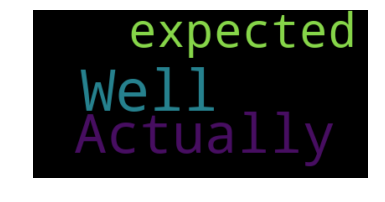

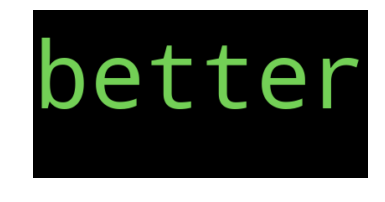

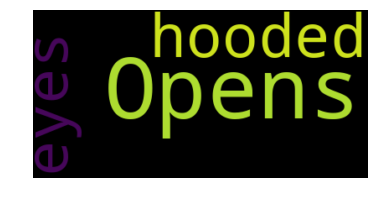

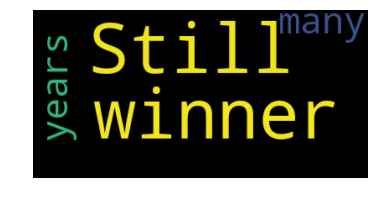

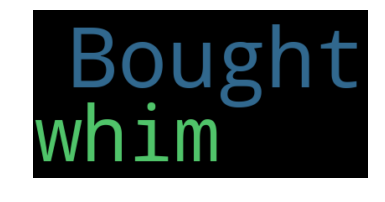

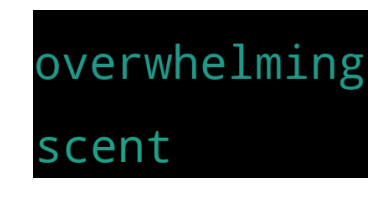

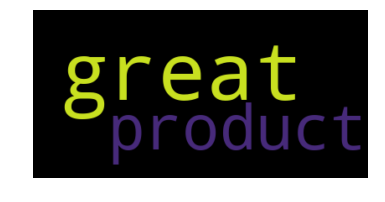

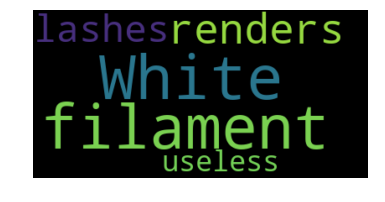

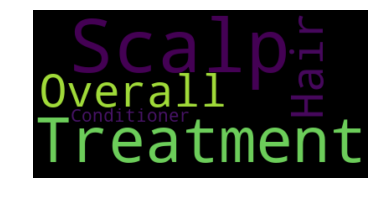

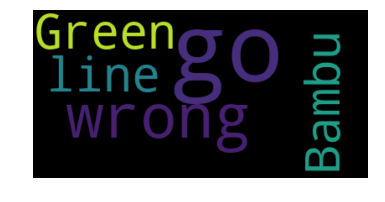

In [93]:
fault_data = np.append(test_y[np.newaxis].T, test_review[np.newaxis].T, axis=1)
fault_data = fault_data[fault_data[:, 0] != predict]

index = np.random.randint(len(fault_data), size=10)
sample_fault = fault_data[index, :]

for text in sample_fault[:, 1]:
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()



In [95]:
sample_fault

array([[0, 'Well...Not Actually what I expected'],
       [1, "Can't get any better"],
       [1, 'Opens hooded eyes'],
       [1, 'Still a winner after many years'],
       [0, 'Bought this on a whim'],
       [0, 'Very overwhelming scent!'],
       [0, 'Its not a great product'],
       [0, 'White filament renders these lashes useless!'],
       [1, 'More of a Scalp Treatment than Overall Hair Conditioner'],
       [1, "Can't go wrong with the Green Bambu line"]], dtype=object)

# Recommendation System

First I implement a basic collaborative filtering recommendation model using tensorrec only based on user_id and item_id (no user or item features). I inherit a DeepRepresentationGraph from AbstractKerasRepresentationGraph and set n_components to 10, 50, 100 respectively to see the influence of different embedding size. In order to evaluate the model performance, the evaluation metric recall at rank 10 is presented. It shows embedding size of 100 has a relatively better performance. 

In [173]:
import scipy.sparse as sp
# Build map between users, items, and rows/columns
user_to_row_map = {}
item_to_column_map = {}
for user, item in np.array(ratings[['user_id', 'item_id']]): 
    if user not in user_to_row_map:
        user_to_row_map[user] = len(user_to_row_map)
    if item not in item_to_column_map:
        item_to_column_map[item] = len(item_to_column_map)

interactions_raw = [(user_to_row_map[user], item_to_column_map[item], 1) for user, item in np.array(ratings[['user_id', 'item_id']])]
r, c, v = zip(*interactions_raw)
interactions = sp.coo_matrix((v, (r, c)), dtype=np.float64)

In [224]:
import tensorrec
import keras as ks
from tensorrec import TensorRec
from tensorrec.representation_graphs import (
    AbstractKerasRepresentationGraph, NormalizedLinearRepresentationGraph, LinearRepresentationGraph
)

class DeepRepresentationGraph(AbstractKerasRepresentationGraph):

    # This method returns an ordered list of Keras layers connecting the user/item features to the user/item
    # representation. When TensorRec learns, the learning will happen in these layers.
    def create_layers(self, n_features, n_components):
        return [
            ks.layers.Dense(n_components * 16, activation='relu'),
            ks.layers.Dense(n_components * 8, activation='relu'),
            ks.layers.Dense(n_components * 2, activation='relu'),
            ks.layers.Dense(n_components, activation='tanh'),
        ]


for n_components in (10, 50, 100):
    n_user = len(np.unique(ratings.user_id))
    n_item = len(np.unique(ratings.item_id))

    #user_features = sp.coo_matrix((n_user, 0), dtype=np.float64)
    #item_features = sp.coo_matrix((n_item, 0), dtype=np.float64)
    user_features = sp.identity(n_user)
    item_features = sp.identity(n_item)

    # Build the model with default parameters
    model = TensorRec(n_components=n_components, item_repr_graph=DeepRepresentationGraph(), user_repr_graph=DeepRepresentationGraph())
    # Fit the model for 5 epochs
    model.fit(interactions, user_features, item_features, epochs=50, verbose=False)

    # Predict scores and ranks for all users and all items
    predictions = model.predict(user_features=user_features,
                                item_features=item_features)
    predicted_ranks = model.predict_rank(user_features=user_features,
                                         item_features=item_features)

    # Calculate and print the recall at 10
    r_at_k = tensorrec.eval.recall_at_k(predicted_ranks, interactions, k=10)
    print(np.mean(r_at_k))

/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.006218867047284522
0.01871250728554204
0.018940103972388975


Next step I will try my best to compare this collaborative filtering approach with content based method in a high-level summary in another pdf file. To be honest, I am not very familiar with recommendation systems. Thanks for your instructions if somewhere goes wrong. 